# Find the approximation of the solution of a differential equation using Surrogates.jl (1D case)

First of all, let's define the differential equation. I will pick a very simple example because the focus is on the approximation technique. 

In [26]:
using DifferentialEquations #differential equation definition
using Plots
using Surrogates
using Cubature #Integral approximation

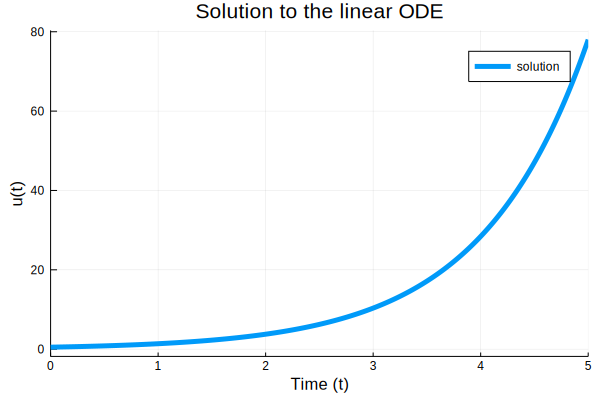

In [27]:
a = 0.0
b = 5.0
f(u,p,t) = 1.01*u
u0 = 1/2
tspan = (a,b)
prob = ODEProblem(f,u0,tspan)
true_solution = t->0.5*exp(1.01t);
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

plot(sol,linewidth=5,title="Solution to the linear ODE",
     xaxis="Time (t)",yaxis="u(t)",label="solution") 

Now we have the true value of the function we want to approximate. In practice, we cannot actually solve the differential equation, because it's computationally expensive! We suppose we can compute in $n$ different points the true value of the function.

## 1) Sampling
There are many ways in which we can take points on the x-axis to find the true value of the function. For example, we can just divide in equal parts the interval $[a,b]$. This is not always the best choice: when using polynomial interpolation it leads to numerical problems. Let's use a more sophisticated technique: Sobol sampling. It is a particular example of Low discrepancy sampling, more info here: https://en.wikipedia.org/wiki/Sobol_sequence.

In [29]:
n = 30 # number of sampling points
lower_bound = 0.0
upper_bound = 5.0
x = sample(n,lower_bound,upper_bound,SobolSample());

30-element Array{Float64,1}:
 2.96875 
 4.21875 
 1.71875 
 2.34375 
 4.84375 
 3.59375 
 1.09375 
 0.78125 
 3.28125 
 4.53125 
 2.03125 
 1.40625 
 3.90625 
 ⋮       
 1.484375
 2.109375
 4.609375
 3.359375
 0.859375
 1.171875
 3.671875
 4.921875
 2.421875
 1.796875
 4.296875
 3.046875

There are many sampling techniques available in Surrogates, more info here: https://surrogates.sciml.ai/stable/samples/


## 2) Surrogate modelling 
Now that we have our sampling points, we need to fit a surrogate. First of all, we need to find the true values of our expensive function:

In [31]:
y = sol.(x)

30-element Array{Float64,1}:
 10.027088894120231 
 35.438199483986295 
  2.837122458353201 
  5.3336740702498195
 66.62236420289229  
 18.850516619448257 
  1.5091405550096377
  1.1006658548582802
 13.74830191811753  
 48.589882026853594 
  3.8900239720074845
  2.06920674669867  
 25.846244757872103 
  ⋮                 
  2.2390945606666794
  4.209406106116372 
 52.57925080078577  
 14.87707696785966  
  1.1910336810014224
  1.6330453254627324
 20.398198137971324 
 72.09225151699751  
  5.771584019002087 
  3.0700583545624163
 38.34777738231308  
 10.850341669987642 

Now, we need to pick a surrogate. There are many choices! Let's see a few of them.

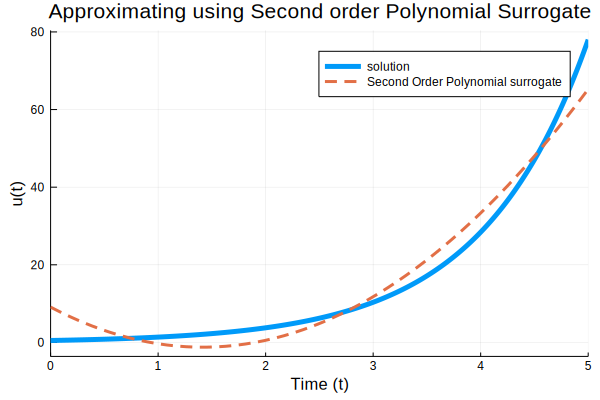

In [32]:
#### Second order polynomial surrogate ### 
second_order_poly = SecondOrderPolynomialSurrogate(x,y,lower_bound,upper_bound)
#Let's plot the solution against my surrogate.
plot(sol,linewidth=5,title="Approximating using Second order Polynomial Surrogate",
     xaxis="Time (t)",yaxis="u(t)",label="solution") # legend=false
plot!(sol.t, t->second_order_poly(t),lw=3,ls=:dash,label="Second Order Polynomial surrogate")

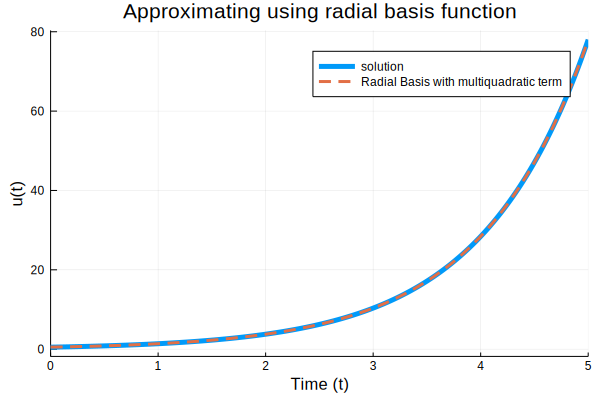

In [33]:
### Radial basis function ###
q = 2
λ = 2.3
multiquadr = x -> sqrt(x^2+λ^2)
my_rad = RadialBasis(x,y,lower_bound,upper_bound,multiquadr,q)

#Let's plot the solution against my surrogate.
plot(sol,linewidth=5,title="Approximating using radial basis function",
     xaxis="Time (t)",yaxis="u(t)",label="solution") # legend=false
plot!(sol.t, t->my_rad(t),lw=3,ls=:dash,label="Radial Basis with multiquadratic term")

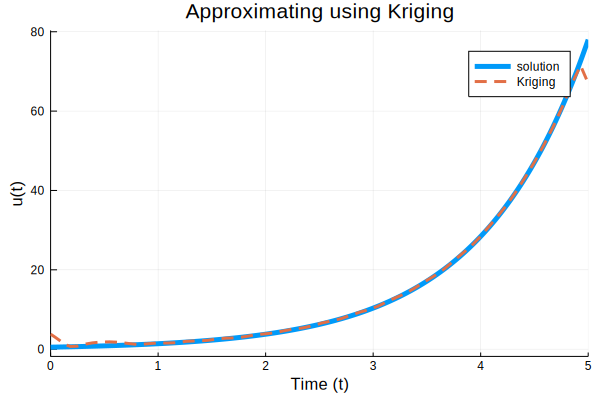

In [34]:
### Kriging ###
p = 0.9
krig = Kriging(x,y,p)

#Let's plot the solution against my surrogate.
plot(sol,linewidth=5,title="Approximating using Kriging",
     xaxis="Time (t)",yaxis="u(t)",label="solution") # legend=false
plot!(sol.t, t->krig(t),lw=3,ls=:dash,label="Kriging")

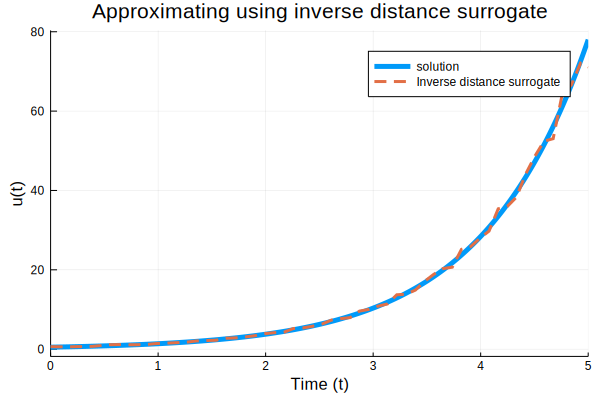

In [35]:
### Inverse Distance surrogate ###
p = 3.0
inv_dist = InverseDistanceSurrogate(x,y,p,lower_bound,upper_bound)


#Let's plot the solution against my surrogate.
plot(sol,linewidth=5,title="Approximating using inverse distance surrogate",
     xaxis="Time (t)",yaxis="u(t)",label="solution") # legend=false
plot!(sol.t, t->inv_dist(t),lw=3,ls=:dash,label="Inverse distance surrogate")

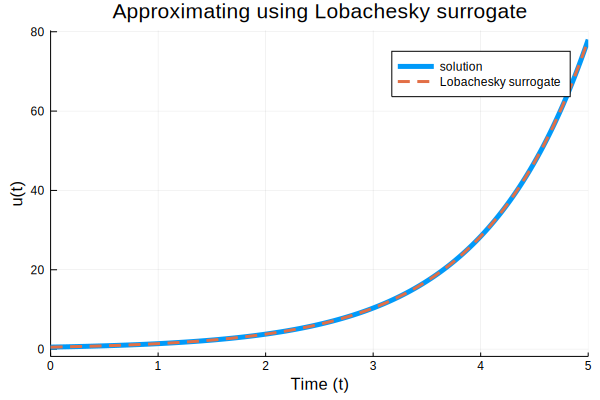

In [36]:
### LOBACHESKY SURROGATE ###
N = 10;
alpha = 0.5;
loba_surrogate = LobacheskySurrogate(x,y,alpha,N,lower_bound,upper_bound)
#Let's plot the solution against my surrogate.
plot(sol,linewidth=5,title="Approximating using Lobachesky surrogate",
     xaxis="Time (t)",yaxis="u(t)",label="solution") # legend=false
plot!(sol.t, t->loba_surrogate(t),lw=3,ls=:dash,label="Lobachesky surrogate")

The lobachesky surrogate has a nice property: there is a closed form solution of the integral!

In [13]:
#integral of the surrogate lobachesky from 0.0 5.0, without using an approximation!
s = 1.0
e = 4.0
value_with_loba = lobachesky_integral(loba_surrogate,s,e); #Closed form solution with Lobachesky
true_value,err = hquadrature(true_solution,s,e); #Cubature to find integral
error_of_loba = abs(value_with_loba-true_value)

1.197511661388262e-6

# Finding the gradient of the surrogate

The great capability of the library is the possibility of taking gradient of the surrogates to approximate the derivative of the true function.

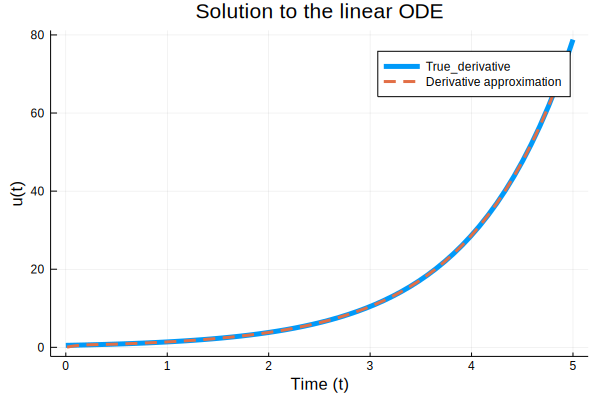

In [38]:
using Zygote
true_der = t -> 1.01*0.5*exp(1.01t)
approx_der = t -> my_rad'(t)
plot(sol.t,true_der,linewidth=5,title="Solution to the linear ODE",
     xaxis="Time (t)",yaxis="u(t)",label="True_derivative") # legend=false
plot!(sol.t, approx_der,lw=3,ls=:dash,label="Derivative approximation")

## 3) Optimization
We now have the surrogate modelling the function. However, we are interested in having a better approximation! We can call and optimization method to simultaneously look for the minima and to sample unknown regions. 

In [13]:
length(loba_surrogate.x)

30

In [14]:
min_x, min_y = surrogate_optimize(t->sol(t),SRBF(),lower_bound,upper_bound,loba_surrogate,SobolSample();maxiters=100,num_new_samples=100)

Out of sampling points


(0.0416545, 0.5214842869104949)

In [15]:
length(loba_surrogate.x)

62

# References
DifferentialEquations.jl: https://docs.juliadiffeq.org/latest/

Surrogates.jl: https://surrogates.sciml.ai/stable/ 
